<a href="https://colab.research.google.com/github/Sahanaka/siamese-networks/blob/main/siamese.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Siamese Network**
In this notebook, we will implement a Siamese Network. We will use the Fashion MNIST dataset to check image similarity.  A regular use case of the Siamese network is facial recognition. 

## **Imports**

In [1]:
try:
# %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

## **Prepare the Dataset**
To check for image similarity, we need to create image pairs. Also we will define and implement a few utilites to plot and view image samples.

In [2]:
# Show image
def show_image(image):
  plt.figure()
  plt.imshow(image)
  plt.colorbar()
  plt.grid(False)
  plt.show()

In [3]:
# Create pairs
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y

### Download & Split the Dataset

In [4]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0

# create pairs on train and test sets
tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

4431872/4422102 [==============================] - 0s 0us/step


Let's see a few examples

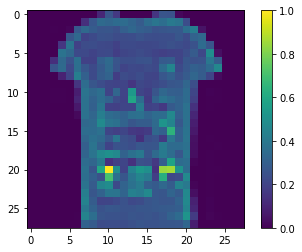

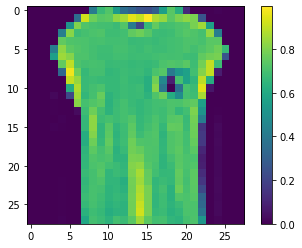

1.0


In [5]:
# array index
this_pair = 14

# show images at this index
show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

# print the label for this pair
print(ts_y[this_pair])

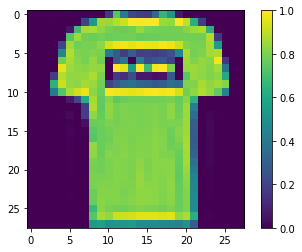

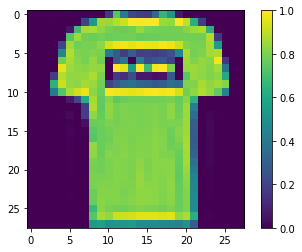

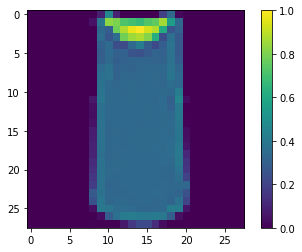

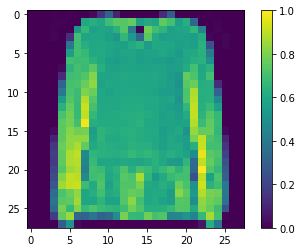

In [6]:
# Another example
show_image(tr_pairs[:,0][0])
show_image(tr_pairs[:,0][1])

show_image(tr_pairs[:,1][0])
show_image(tr_pairs[:,1][1])

## **Model**

We will first define the base model

In [7]:
def initialize_base_network():
  input = Input(shape=(28,28,), name="base_input")
  x = Flatten(name="flatten_input")(input)
  x = Dense(128, activation='relu', name="first_base_dense")(x)
  x = Dropout(0.1, name="first_dropout")(x)
  x = Dense(128, activation='relu', name="second_base_dense")(x)
  x = Dropout(0.1, name="second_dropout")(x)
  x = Dense(128, activation='relu', name="third_base_dense")(x)

  return Model(inputs=input, outputs=x)

In [8]:
# Define Eucledian Distance
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [9]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

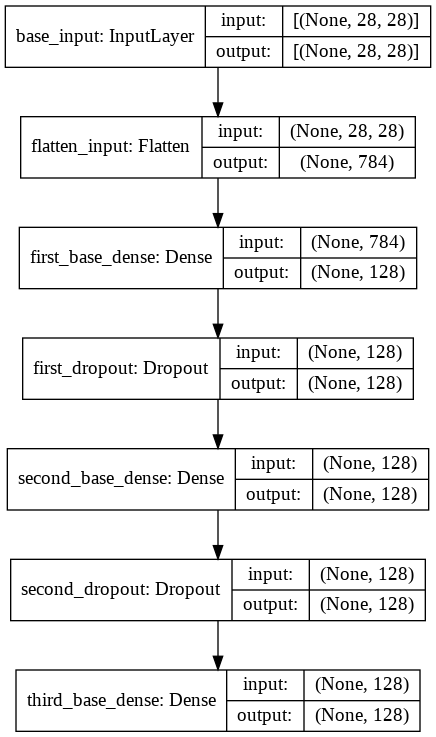

In [10]:
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True)

### Build the Siamese Network
Now we will build the Siamese network with the defined base network. The diagram will display the architecture of the model.

In [11]:
def siamese_network():
  input_a = Input(shape=(28, 28), name='left_input')
  vect_output_a = base_network(input_a)

  input_b = Input(shape=(28, 28), name='right_input')
  vect_output_b = base_network(input_b)

  output = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape, name='output_layer')([vect_output_a, vect_output_b])

  model = Model(inputs=[input_a, input_b], outputs=output)
  return model


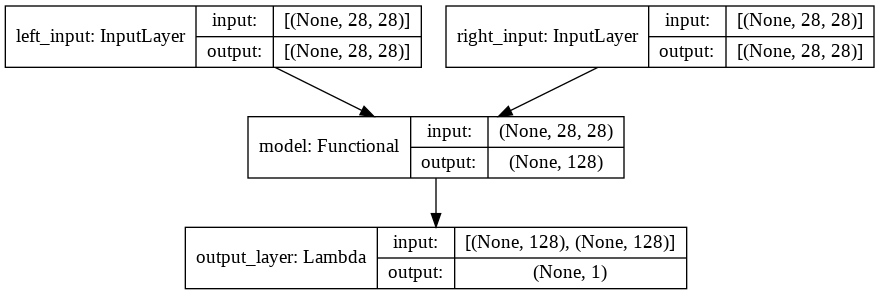

In [12]:
model = siamese_network()
plot_model(model, show_shapes=True, show_layer_names=True)

### Train the Model

In [13]:
# Define a custom loss function
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [14]:
rms = RMSprop()
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=rms, metrics=['accuracy'])
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=20, batch_size=128, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Epoch 1/20
938/938 [==============================] - 9s 6ms/step - loss: 0.1107 - accuracy: 0.1410 - val_loss: 0.0859 - val_accuracy: 0.1123
Epoch 2/20
938/938 [==============================] - 6s 6ms/step - loss: 0.0798 - accuracy: 0.1011 - val_loss: 0.0737 - val_accuracy: 0.0971
Epoch 3/20
938/938 [==============================] - 5s 6ms/step - loss: 0.0710 - accuracy: 0.0886 - val_loss: 0.0698 - val_accuracy: 0.0881
Epoch 4/20
938/938 [==============================] - 6s 6ms/step - loss: 0.0669 - accuracy: 0.0849 - val_loss: 0.0670 - val_accuracy: 0.0867
Epoch 5/20
938/938 [==============================] - 6s 6ms/step - loss: 0.0635 - accuracy: 0.0824 - val_loss: 0.0644 - val_accuracy: 0.0869
Epoch 6/20
938/938 [==============================] - 5s 6ms/step - loss: 0.0608 - accuracy: 0.0800 - val_loss: 0.0683 - val_accuracy: 0.0929
Epoch 7/20
938/938 [==============================] - 5s 6ms/step - loss: 0.0593 - accuracy: 0.0781 - val_loss: 0.0671 - val_accuracy: 0.0913
Epoch 

## **Evaluation**
We will see the test set's results and also plot the learning curves. 

In [15]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [16]:
loss = model.evaluate(x=[ts_pairs[:,0],ts_pairs[:,1]], y=ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

625/625 [==============================] - 2s 3ms/step - loss: 0.0637 - accuracy: 0.0863
Loss = [0.06366430222988129, 0.0862862840294838], Train Accuracy = 0.9394149024837473 Test Accuracy = 0.9137137137137137


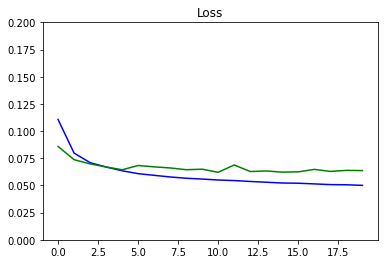

In [17]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

### Visualization

In [18]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts


# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)

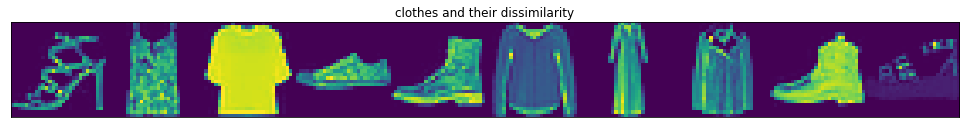

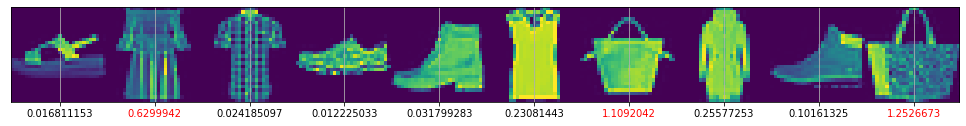

In [19]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=10)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 10)

## **Save Model**
We will save the model in Google Drive and load it to see everything works

In [ ]:
# Mound Gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
MODEL_SAVED_PATH = './drive/MyDrive/siamese_model'

In [ ]:
model.save(MODEL_SAVED_PATH)

INFO:tensorflow:Assets written to: ./drive/MyDrive/siamese_model/assets


### Load the saved Model

In [ ]:
reloaded_model = tf.saved_model.load(MODEL_SAVED_PATH)

In [ ]:
# y_pred_test = reloaded_model.predict([ts_pairs[:,0], ts_pairs[:,1]])
# test_accuracy = compute_accuracy(ts_y, y_pred_test)

# print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))
reloaded_model.trainable_variables

ListWrapper([<tf.Variable 'first_base_dense/kernel:0' shape=(784, 128) dtype=float32, numpy=
array([[-0.0302675 , -0.01218375, -0.03921645, ...,  0.05475696,
         0.02503476, -0.01094852],
       [ 0.02366254,  0.0041478 , -0.00735076, ..., -0.05493721,
        -0.04685437,  0.12335963],
       [ 0.0075974 ,  0.02210358,  0.0546609 , ...,  0.03856269,
        -0.07957481,  0.10433896],
       ...,
       [-0.4078589 , -0.03074715,  0.05413671, ...,  0.03355291,
         0.03091639, -0.11987424],
       [-0.2531988 , -0.19154477,  0.02540781, ...,  0.010523  ,
        -0.05577575, -0.05135987],
       [-0.02536653, -0.15751915,  0.07782897, ...,  0.05726917,
         0.02423611, -0.02234243]], dtype=float32)>, <tf.Variable 'first_base_dense/bias:0' shape=(128,) dtype=float32, numpy=
array([-2.37023786e-01,  4.46503609e-01,  3.40904474e-01, -2.12189391e-01,
        2.46880859e-01,  6.94621056e-02, -1.30984150e-02,  1.21541336e-01,
       -9.92500223e-03,  2.62732893e-01,  5.86264394e